# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [13]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS/2020/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS/2020/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS/2020/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
GP_model = joblib.load('GP_trained_model.joblib')
LR_model = joblib.load('LR_trained_model.joblib')

Defined Functions

In [14]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [15]:
def convert_kg_to_cms_cfsr(df):

    # Calculate the number of seconds for each month
    df['seconds'] = df.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # Convert kg to meters cubed and divide by the seconds in the month
    df['WaterErie_cms'] = (df['WaterErie'] / 1000) / df['seconds']
    df['WaterOntario_cms'] = (df['WaterOntario'] / 1000) / df['seconds']
    df['WaterSuperior_cms'] = (df['WaterSuperior'] / 1000) / df['seconds']
    df['WaterMichHuron_cms'] = ((df['WaterMichigan'] + df['WaterHuron']) / 1000) / df['seconds']
    df['LandErie_cms'] = (df['LandErie'] / 1000) / df['seconds']
    df['LandOntario_cms'] = (df['LandOntario'] / 1000) / df['seconds']
    df['LandSuperior_cms'] = (df['LandSuperior'] / 1000) / df['seconds']
    df['LandMichHuron_cms'] = ((df['LandMichigan'] + df['LandHuron']) / 1000) / df['seconds']
    
    return df

In [16]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [17]:
# Read in GLCC RNBS data
data_4 = pd.read_csv(dir + 'Input/rnbs_glcc.csv', sep=',')

# Ensure 'Date' column is treated as string and modified as necessary
date_strs = data_4['Date'].astype(str)

date_rnbs = []

for date_str in date_strs:
    # Insert leading zero before month (if necessary)
    if len(date_str) == 6:
        date_str = date_str[:4] + '0' + date_str[4:]

    # Insert leading zero before day (if necessary)
    if len(date_str) == 7:
        date_str = date_str[:6] + '0' + date_str[6:]

    # Convert to datetime object
    datetime_obj = datetime.strptime(date_str, '%Y%m%d')

    # Format the datetime object as a string in the desired format
    date_tmp = datetime_obj.strftime('%Y-%m-%d')

    # Append formatted date to list
    date_rnbs.append(date_tmp)

# Replace the original 'Date' column with formatted dates
data_4['Date'] = date_rnbs

# Convert 'Date' column to datetime format
data_4['Date'] = pd.to_datetime(data_4['Date'])

# Add a new column 'Month' extracting month from 'Date'
data_4['Month'] = data_4['Date'].dt.month

# Select only the data that matches with the CFSR dates
start_date = '2020-01-01'
end_date = '2020-12-01'
obs = data_4[(data_4['Date'] >= start_date) & (data_4['Date'] <= end_date)]

su_rnbs = obs['sup']
er_rnbs = obs['eri']
on_rnbs = obs['ont']
mh_rnbs = obs['mic_hur']

In [18]:
print(obs)

           Date         sup     mic_hur         eri         ont  Month
1440 2020-01-01   12.750390  129.966000  239.331100  334.782500      1
1441 2020-02-01  -29.972390   43.529040   38.465750  163.799000      2
1442 2020-03-01   94.156750  170.995800  212.973100  369.801600      3
1443 2020-04-01   89.221120  171.469100   83.665560  229.092600      4
1444 2020-05-01  120.965300  217.756100  145.496500  190.503800      5
1445 2020-06-01  124.972800  132.206400   12.243740   63.712150      6
1446 2020-07-01  140.254300   95.354250  -10.543220   49.026720      7
1447 2020-08-01   73.233030   76.100030  -83.291450    1.400764      8
1448 2020-09-01   77.514800    7.320154 -147.945200  -71.845610      9
1449 2020-10-01    7.846396   24.984650  -55.879070    7.003818     10
1450 2020-11-01   43.977780   39.040820   -5.101559   55.578680     11
1451 2020-12-01  -52.309310   56.845800   68.530940  142.877900     12


## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [19]:
# Convert Total Precipitation to cms
pcp_data = convert_kg_to_cms_cfsr(pcp_data)

# Convert Total Evaporation to cms
evap_data = convert_kg_to_cms_cfsr(evap_data)

In [20]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2020010100  2020      1  5.039449e+12  8.437616e+11  4.924873e+12   
1      2020010100  2020      2  5.103290e+12  8.769925e+11  4.913393e+12   
2      2020010100  2020      3  1.172140e+13  1.851843e+12  1.139989e+13   
3      2020010100  2020      4  5.899706e+12  9.391540e+11  5.870735e+12   
4      2020010100  2020      5  7.103447e+12  1.102071e+12  7.109200e+12   
...           ...   ...    ...           ...           ...           ...   
13955  2020123018  2021      5  4.916998e+12  7.517275e+11  4.754891e+12   
13956  2020123018  2021      6  8.294270e+12  1.201716e+12  8.365534e+12   
13957  2020123018  2021      7  1.112022e+13  1.672541e+12  1.097369e+13   
13958  2020123018  2021      8  1.162130e+13  2.030638e+12  1.065492e+13   
13959  2020123018  2021      9  9.481841e+12  1.513401e+12  9.132614e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      3.675493e+

In [21]:
print(pcp_data)

           cfsrun  year  month     BasinErie     WaterErie      LandErie  \
0      2020010100  2020      1  5.039449e+12  8.437616e+11  4.924873e+12   
1      2020010100  2020      2  5.103290e+12  8.769925e+11  4.913393e+12   
2      2020010100  2020      3  1.172140e+13  1.851843e+12  1.139989e+13   
3      2020010100  2020      4  5.899706e+12  9.391540e+11  5.870735e+12   
4      2020010100  2020      5  7.103447e+12  1.102071e+12  7.109200e+12   
...           ...   ...    ...           ...           ...           ...   
13955  2020123018  2021      5  4.916998e+12  7.517275e+11  4.754891e+12   
13956  2020123018  2021      6  8.294270e+12  1.201716e+12  8.365534e+12   
13957  2020123018  2021      7  1.112022e+13  1.672541e+12  1.097369e+13   
13958  2020123018  2021      8  1.162130e+13  2.030638e+12  1.065492e+13   
13959  2020123018  2021      9  9.481841e+12  1.513401e+12  9.132614e+12   

       BasinOntario  WaterOntario   LandOntario    BasinHuron  ...  \
0      3.675493e+

In [23]:
# Features
X = pd.DataFrame({
    'su_pcp_w': pcp_data['WaterSuperior_cms'],
    'er_pcp_w': pcp_data['WaterErie_cms'],
    'on_pcp_w': pcp_data['WaterOntario_cms'],
    'mh_pcp_w': pcp_data['WaterMichHuron_cms'], #data_1['WaterMichigan']+data_1['WaterHuron'], # add the sums
    'su_pcp_l': pcp_data['LandSuperior_cms'],
    'er_pcp_l': pcp_data['LandErie_cms'],
    'on_pcp_l': pcp_data['LandOntario_cms'],
    'mh_pcp_l': pcp_data['LandMichHuron_cms'],
    'su_evap_w': evap_data['WaterSuperior_cms'],
    'er_evap_w': evap_data['WaterErie_cms'],
    'on_evap_w': evap_data['WaterOntario_cms'],
    'mh_evap_w': evap_data['WaterMichHuron_cms'], #data_2['WaterMichigan']+data_2['WaterHuron'], # add the sums
    'su_evap_l': evap_data['LandSuperior_cms'],
    'er_evap_l': evap_data['LandErie_cms'],
    'on_evap_l': evap_data['LandOntario_cms'],
    'mh_evap_l': evap_data['LandMichHuron_cms'],
    'su_tmp_w': tmp_data['WaterSuperior'],
    'er_tmp_w': tmp_data['WaterErie'],
    'on_tmp_w': tmp_data['WaterOntario'],
    'mh_tmp_w': (tmp_data['WaterMichigan']+tmp_data['WaterHuron'])/2,
    'su_tmp_l': tmp_data['LandSuperior'],
    'er_tmp_l': tmp_data['LandErie'],
    'on_tmp_l': tmp_data['LandOntario'],
    'mh_tmp_l': (tmp_data['LandMichigan']+tmp_data['LandHuron'])/2 # take the average temp
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [29]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

y_pred_scaled_gp = GP_model.predict(X_scaled)

y_pred_gp = y_scaler.inverse_transform(y_pred_scaled_gp) # unscale the predictions
df_y_gp = pd.DataFrame(y_pred_gp, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_gp)

           su_evap    su_precip    su_runoff      er_evap    er_precip  \
0      1592.516378   838.971781   708.408865   235.091442   376.150345   
1      1593.030388  1155.108197   470.804505   146.090793   379.650860   
2      2547.822668  1269.094119   568.090005   330.508815  1031.045906   
3      1684.754674   963.243621  1198.189401   481.356566   506.545192   
4       879.111821  2791.258918  1740.957449   973.702156   886.322562   
...            ...          ...          ...          ...          ...   
13955   861.791344  3092.848189  1645.572983  1138.901673   760.384687   
13956   946.531806  1809.214499   946.186460  1199.681597  1044.045573   
13957   998.326623  2468.863306   719.854685  1183.960329  1104.941633   
13958   786.448318  1634.338746   505.146581  1266.807680  1102.857884   
13959  1206.680964  3401.662130  1121.423874  1110.038344  1141.133014   

         er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
0       776.495007  273.207234  268.228

In [30]:
# Predict using LR NO SCALING
y_pred_lr = LR_model.predict(X)

df_y_lr = pd.DataFrame(y_pred_lr, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_lr)

           su_evap    su_precip    su_runoff      er_evap    er_precip  \
0      1853.771206   930.578000  1273.427676   230.749314   386.150139   
1      2467.424549  1078.840286  1351.790163   246.978208   341.756280   
2      2497.576395  1240.984474  1243.906691   279.812384   977.115377   
3      1170.235236  1396.429536  1421.434491   424.383459   521.964669   
4       521.921453  3320.138672  2464.879792   922.256768   733.366156   
...            ...          ...          ...          ...          ...   
13955   664.449706  3451.548168  2788.288427  1244.732586   555.164056   
13956   756.122791  2157.742472  2004.520622  1100.062012   965.657876   
13957   608.614273  3111.908413  1925.007628  1362.609313  1176.535982   
13958   820.476214  1730.316271  1365.488209  1223.437389  1259.668455   
13959  1225.192981  3885.195267  1994.656388  1249.998226  1087.892397   

         er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
0       742.136775  350.793452  304.282

In [31]:
df = pd.DataFrame()
df['cfsrun'] = pcp_data['cfsrun']
df['month'] = pcp_data['month'].astype(int)
df['year'] = pcp_data['year'].astype(int)

In [32]:
df_gp = pd.merge(df, df_y_gp, left_index=True, right_index=True, how='inner')
df_lr = pd.merge(df, df_y_lr, left_index=True, right_index=True, how='inner')

In [33]:
print(df_gp)

           cfsrun  month  year      su_evap    su_precip    su_runoff  \
0      2020010100      1  2020  1592.516378   838.971781   708.408865   
1      2020010100      2  2020  1593.030388  1155.108197   470.804505   
2      2020010100      3  2020  2547.822668  1269.094119   568.090005   
3      2020010100      4  2020  1684.754674   963.243621  1198.189401   
4      2020010100      5  2020   879.111821  2791.258918  1740.957449   
...           ...    ...   ...          ...          ...          ...   
13955  2020123018      5  2021   861.791344  3092.848189  1645.572983   
13956  2020123018      6  2021   946.531806  1809.214499   946.186460   
13957  2020123018      7  2021   998.326623  2468.863306   719.854685   
13958  2020123018      8  2021   786.448318  1634.338746   505.146581   
13959  2020123018      9  2021  1206.680964  3401.662130  1121.423874   

           er_evap    er_precip    er_runoff     on_evap   on_precip  \
0       235.091442   376.150345   776.495007  273.2

Currently, we are only storing 1 set of model results

In [34]:
def calculate_cnbs(df, prefix):
    """
    Calculate CNBS values based on the provided prefix.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the relevant data.
    prefix (str): The prefix for the relevant columns (e.g., 'su', 'er', 'on', 'mh').

    Returns:
    pd.DataFrame: The DataFrame with new CNBS columns added.
    """
    cnbs_column = f'{prefix}_cnbs'
    df[cnbs_column] = df[f'{prefix}_precip'] + df[f'{prefix}_runoff'] - df[f'{prefix}_evap']
    return df

In [35]:
df_gp = calculate_cnbs(df_gp, 'su')
df_gp = calculate_cnbs(df_gp, 'mh')
df_gp = calculate_cnbs(df_gp, 'er')
df_gp = calculate_cnbs(df_gp, 'on')

print(df_gp)

           cfsrun  month  year      su_evap    su_precip    su_runoff  \
0      2020010100      1  2020  1592.516378   838.971781   708.408865   
1      2020010100      2  2020  1593.030388  1155.108197   470.804505   
2      2020010100      3  2020  2547.822668  1269.094119   568.090005   
3      2020010100      4  2020  1684.754674   963.243621  1198.189401   
4      2020010100      5  2020   879.111821  2791.258918  1740.957449   
...           ...    ...   ...          ...          ...          ...   
13955  2020123018      5  2021   861.791344  3092.848189  1645.572983   
13956  2020123018      6  2021   946.531806  1809.214499   946.186460   
13957  2020123018      7  2021   998.326623  2468.863306   719.854685   
13958  2020123018      8  2021   786.448318  1634.338746   505.146581   
13959  2020123018      9  2021  1206.680964  3401.662130  1121.423874   

           er_evap    er_precip    er_runoff     on_evap   on_precip  \
0       235.091442   376.150345   776.495007  273.2

In [36]:
df_lr = calculate_cnbs(df_lr, 'su')
df_lr = calculate_cnbs(df_lr, 'mh')
df_lr = calculate_cnbs(df_lr, 'er')
df_lr = calculate_cnbs(df_lr, 'on')

print(df_lr)

           cfsrun  month  year      su_evap    su_precip    su_runoff  \
0      2020010100      1  2020  1853.771206   930.578000  1273.427676   
1      2020010100      2  2020  2467.424549  1078.840286  1351.790163   
2      2020010100      3  2020  2497.576395  1240.984474  1243.906691   
3      2020010100      4  2020  1170.235236  1396.429536  1421.434491   
4      2020010100      5  2020   521.921453  3320.138672  2464.879792   
...           ...    ...   ...          ...          ...          ...   
13955  2020123018      5  2021   664.449706  3451.548168  2788.288427   
13956  2020123018      6  2021   756.122791  2157.742472  2004.520622   
13957  2020123018      7  2021   608.614273  3111.908413  1925.007628   
13958  2020123018      8  2021   820.476214  1730.316271  1365.488209   
13959  2020123018      9  2021  1225.192981  3885.195267  1994.656388   

           er_evap    er_precip    er_runoff     on_evap   on_precip  \
0       230.749314   386.150139   742.136775  350.7

In [39]:
df_gp_filtered = df_gp[(df_gp['year'] == 2020)]
print(df_gp_filtered)

df_gp_filtered.to_csv(dir+f'CNBS_2020_GP_cms.csv',sep=',',index=False)

           cfsrun  month  year      su_evap    su_precip    su_runoff  \
0      2020010100      1  2020  1592.516378   838.971781   708.408865   
1      2020010100      2  2020  1593.030388  1155.108197   470.804505   
2      2020010100      3  2020  2547.822668  1269.094119   568.090005   
3      2020010100      4  2020  1684.754674   963.243621  1198.189401   
4      2020010100      5  2020   879.111821  2791.258918  1740.957449   
...           ...    ...   ...          ...          ...          ...   
13910  2020122918     12  2020  2660.629590  1682.937103   755.683429   
13920  2020123000     12  2020  2582.754412  2349.721407   982.159895   
13930  2020123006     12  2020  2384.932881  2539.900985  1108.468039   
13940  2020123012     12  2020  2116.443316  1702.737234   793.282088   
13950  2020123018     12  2020  2172.002684  1295.499404   508.845701   

          er_evap    er_precip    er_runoff     on_evap   on_precip  \
0      235.091442   376.150345   776.495007  273.207

In [40]:
df_lr_filtered = df_lr[(df_lr['year'] == 2020)]
print(df_lr_filtered)

df_lr_filtered.to_csv(dir+f'CNBS_2020_LR_cms.csv',sep=',',index=False)

           cfsrun  month  year      su_evap    su_precip    su_runoff  \
0      2020010100      1  2020  1853.771206   930.578000  1273.427676   
1      2020010100      2  2020  2467.424549  1078.840286  1351.790163   
2      2020010100      3  2020  2497.576395  1240.984474  1243.906691   
3      2020010100      4  2020  1170.235236  1396.429536  1421.434491   
4      2020010100      5  2020   521.921453  3320.138672  2464.879792   
...           ...    ...   ...          ...          ...          ...   
13910  2020122918     12  2020  2893.599537  1823.279818  1108.269046   
13920  2020123000     12  2020  2980.016748  2324.003362  1412.586186   
13930  2020123006     12  2020  2784.345882  2502.749464  1235.145275   
13940  2020123012     12  2020  2782.425537  1233.976672   910.078892   
13950  2020123018     12  2020  2666.440934   470.297638   810.115153   

          er_evap    er_precip    er_runoff     on_evap    on_precip  \
0      230.749314   386.150139   742.136775  350.79

Convert component units from [cms] to [mm]

In [41]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [45]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mh"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [46]:
df_gp_mm = convert_cms_to_mm(df_gp_filtered)
df_lr_mm = convert_cms_to_mm(df_lr_filtered)

In [47]:
print(df_gp_mm)

           cfsrun  month  year    su_evap  su_precip  su_runoff     er_evap  \
0      2020010100      1  2020  51.955563  27.371305  23.111713   24.543712   
1      2020010100      2  2020  48.619279  35.253896  14.368951   14.267982   
2      2020010100      3  2020  83.122261  41.403970  18.533835   34.505352   
3      2020010100      4  2020  53.191762  30.411921  37.829725   48.632868   
4      2020010100      5  2020  28.680867  91.064325  56.798427  101.655188   
...           ...    ...   ...        ...        ...        ...         ...   
13910  2020122918     12  2020  86.802566  54.905523  24.654037   64.338666   
13920  2020123000     12  2020  84.261903  76.659242  32.042792   64.639834   
13930  2020123006     12  2020  77.808010  82.863817  36.163572   58.920484   
13940  2020123012     12  2020  69.048586  55.551499  25.880687   62.358473   
13950  2020123018     12  2020  70.861201  42.265437  16.601000   47.675832   

        er_precip   er_runoff    on_evap   on_preci

In [50]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].median().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_gp_mm,'su_cnbs')
mean_er, min_er, max_er = mean_min_max(df_gp_mm,'er_cnbs')
mean_on, min_on, max_on = mean_min_max(df_gp_mm,'on_cnbs')
mean_mh, min_mh, max_mh = mean_min_max(df_gp_mm,'mh_cnbs')

In [53]:
mean_su_lr, min_su_lr, max_su_lr = mean_min_max(df_lr_mm,'su_cnbs')
mean_er_lr, min_er_lr, max_er_lr = mean_min_max(df_lr_mm,'er_cnbs')
mean_on_lr, min_on_lr, max_on_lr = mean_min_max(df_lr_mm,'on_cnbs')
mean_mh_lr, min_mh_lr, max_mh_lr = mean_min_max(df_lr_mm,'mh_cnbs')

Begin plotting

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

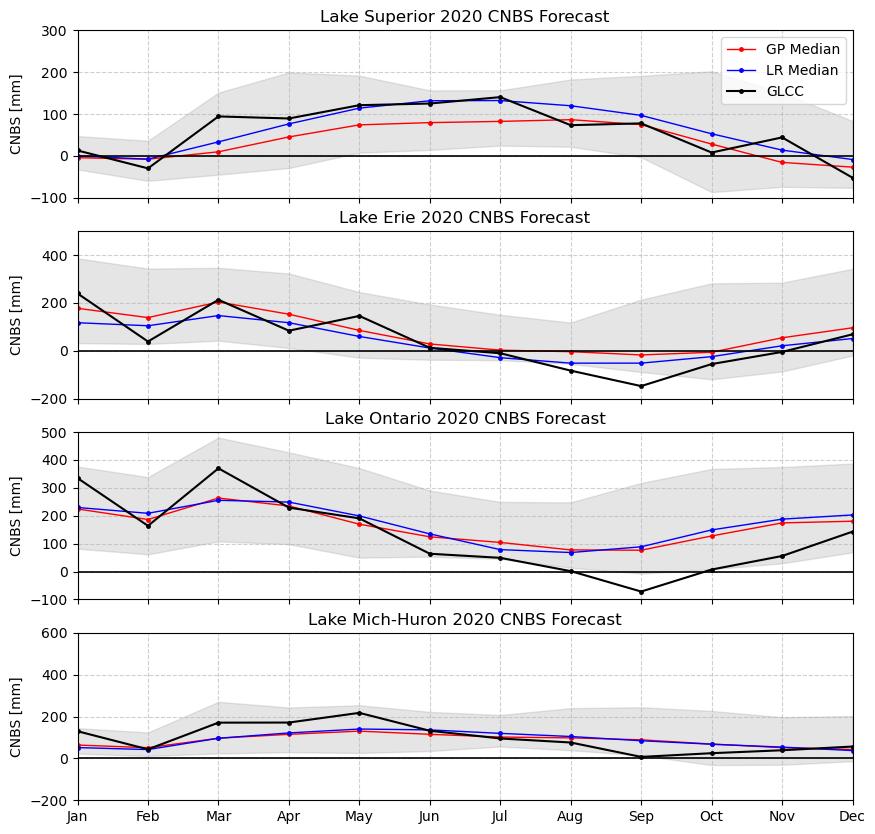

In [66]:
x_values = np.arange(0,12,1)  # x-axis values

# Creating a 4x1 grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(x_values, mean_su['su_cnbs'][0:12], color='red', marker='o', markersize = 2.5, linestyle='-', linewidth=1, label='GP Median')
axs[0].plot(x_values, mean_su_lr['su_cnbs'][0:12], color='blue', marker='o', markersize = 2.5, linestyle='-', linewidth=1, label='LR Median')
axs[0].plot(x_values, su_rnbs, color='black', linestyle='-', linewidth=1.5, marker='o', markersize = 2.5, label='GLCC')
axs[0].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[0].fill_between(x_values, min_su['su_cnbs'][0:12], max_su['su_cnbs'][0:12], color='gray', alpha=0.2)
axs[0].set_ylabel('CNBS [mm]')
axs[0].set_title('Lake Superior 2020 CNBS Forecast')
axs[0].set_ylim(-100, 300)
axs[0].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[0].set_xticks(np.arange(0,12,1))
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].plot(x_values, mean_er['er_cnbs'][0:12], color='red', marker='o', markersize = 2.5, linestyle='-', linewidth=1)
axs[1].plot(x_values, mean_er_lr['er_cnbs'][0:12], color='blue', marker='o', markersize = 2.5, linestyle='-', linewidth=1)
axs[1].plot(x_values, er_rnbs, color='black', linestyle='-', linewidth=1.5, marker='o', markersize = 2.5)
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[1].fill_between(x_values, min_er['er_cnbs'][0:12], max_er['er_cnbs'][0:12], color='gray', alpha=0.2)
axs[1].set_ylabel('CNBS [mm]')
axs[1].set_title('Lake Erie 2020 CNBS Forecast')
axs[1].set_ylim(-200, 500)
axs[1].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[1].set_xticks(np.arange(0,12,1))
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[2].plot(x_values, mean_on['on_cnbs'][0:12], color='red', marker='o', markersize = 2.5, linestyle='-', linewidth=1)
axs[2].plot(x_values, mean_on_lr['on_cnbs'][0:12], color='blue', marker='o', markersize = 2.5, linestyle='-', linewidth=1)
axs[2].plot(x_values, on_rnbs, color='black', linestyle='-', linewidth=1.5, marker='o', markersize = 2.5)
axs[2].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[2].fill_between(x_values, min_on['on_cnbs'][0:12], max_on['on_cnbs'][0:12], color='gray', alpha=0.2)
axs[2].set_ylabel('CNBS [mm]')
axs[2].set_title('Lake Ontario 2020 CNBS Forecast')
axs[2].set_ylim(-100, 500)
axs[2].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[2].set_xticks(np.arange(0,12,1))
axs[2].grid(True, linestyle='--', alpha=0.6)

axs[3].plot(x_values, mean_mh['mh_cnbs'][0:12], color='red', marker='o', markersize = 2.5, linestyle='-', linewidth=1)
axs[3].plot(x_values, mean_mh_lr['mh_cnbs'][0:12], color='blue', marker='o', markersize = 2.5, linestyle='-', linewidth=1)
axs[3].plot(x_values, mh_rnbs, color='black', linestyle='-', linewidth=1.5, marker='o', markersize = 2.5)
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
axs[3].fill_between(x_values, min_mh['mh_cnbs'][0:12], max_mh['mh_cnbs'][0:12], color='gray', alpha=0.2)
axs[3].set_ylabel('CNBS [mm]')
axs[3].set_title('Lake Mich-Huron 2020 CNBS Forecast')
axs[3].set_ylim(-200, 600)
axs[3].set_xlim(0, 11)  # Setting x-axis limits from 1 to 12
axs[3].set_xticks(np.arange(0,12,1))
axs[3].grid(True, linestyle='--', alpha=0.6)
axs[3].set_xticklabels([calendar.month_abbr[mean_mh['month'][j]] for j in range(12)])

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_6152\3635812701.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_6152\3635812701.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


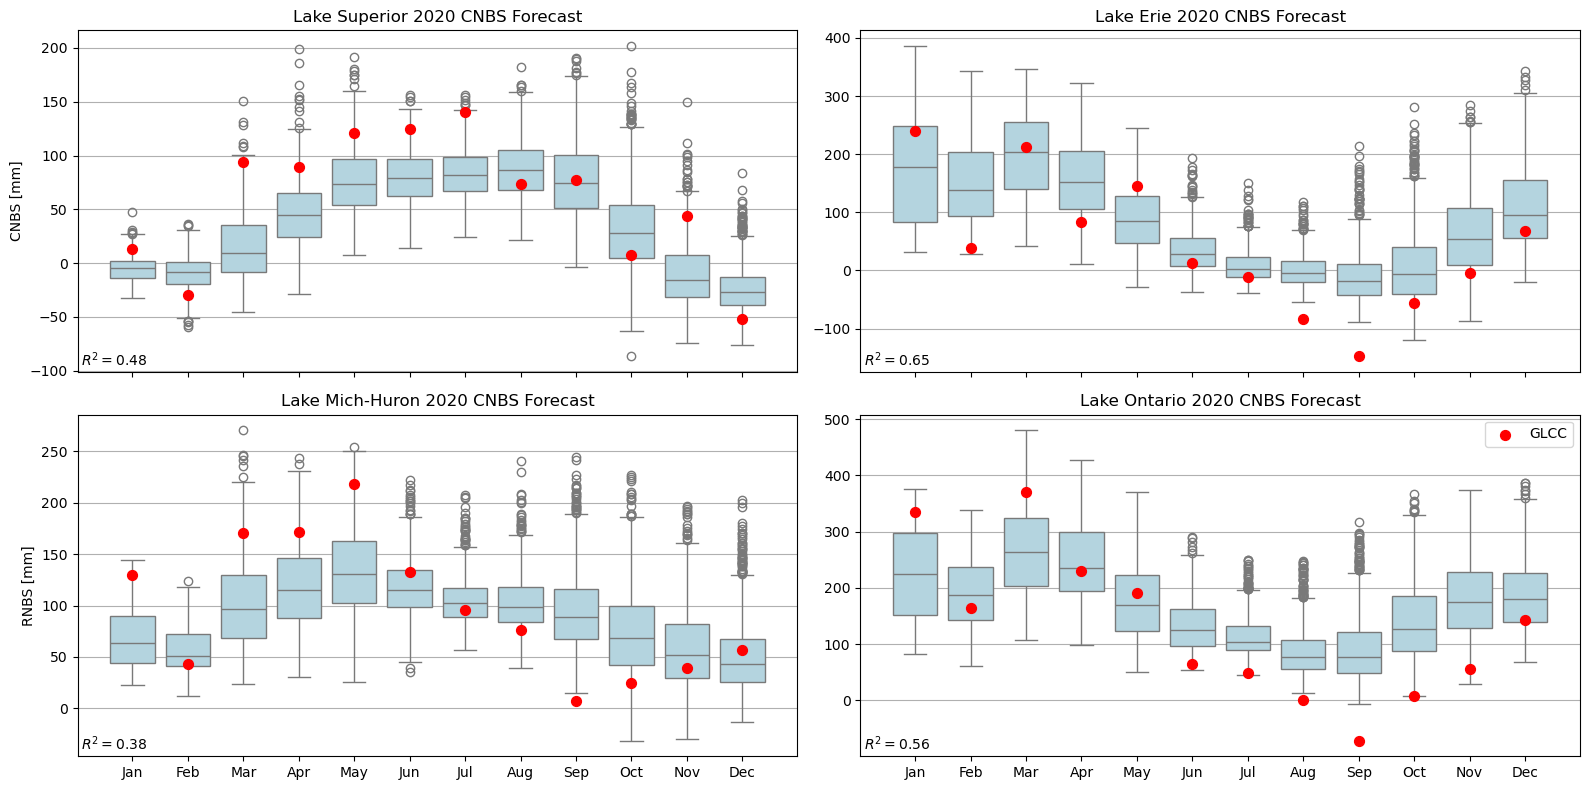

In [62]:
import seaborn as sns
from sklearn.metrics import r2_score

months = np.arange(0, 12)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# First boxplot
sns.boxplot(x='month', y='su_cnbs', data=df_gp_mm, color='lightblue', ax=axes[0, 0])
axes[0, 0].set_title('Lake Superior 2020 CNBS Forecast')
# Scatter plot for observations
axes[0, 0].scatter(obs['Month']-1, obs['sup'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 0].set_ylabel('CNBS [mm]')
axes[0, 0].set_xlabel('')
axes[0, 0].set_xticklabels('')
axes[0, 0].grid(axis='y')

r2_1 = r2_score(obs['sup'],df_gp_mm.groupby('month')['su_cnbs'].median())
axes[0, 0].text(0.005, 0.009, f'$R^2 = {r2_1:.2f}$', ha='left', va='bottom', transform=axes[0, 0].transAxes)

# Second boxplot
sns.boxplot(x='month', y='er_cnbs', data=df_gp_mm, color='lightblue', ax=axes[0, 1])
axes[0, 1].set_title('Lake Erie 2020 CNBS Forecast')
# Scatter plot for observations
axes[0, 1].scatter(obs['Month']-1, obs['eri'], color='red', label='GLCC', s=50, zorder=5)
axes[0, 1].set_ylabel('')
axes[0, 1].set_xlabel('')
axes[0, 1].set_xticklabels('')
axes[0, 1].grid(axis='y')

r2_2 = r2_score(obs['eri'],df_gp_mm.groupby('month')['er_cnbs'].median())
axes[0, 1].text(0.005, 0.009, f'$R^2 = {r2_2:.2f}$', ha='left', va='bottom', transform=axes[0, 1].transAxes)

# Third boxplot
sns.boxplot(x='month', y='mh_cnbs', data=df_gp_mm, color='lightblue', ax=axes[1, 0])
axes[1, 0].set_title('Lake Mich-Huron 2020 CNBS Forecast')
# Scatter plot for observations
axes[1, 0].scatter(obs['Month']-1, obs['mic_hur'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 0].set_ylabel('RNBS [mm]')
axes[1, 0].set_xlabel('')
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(axis='y')

r2_3 = r2_score(obs['mic_hur'],df_gp_mm.groupby('month')['mh_cnbs'].median())
axes[1, 0].text(0.005, 0.009, f'$R^2 = {r2_3:.2f}$', ha='left', va='bottom', transform=axes[1, 0].transAxes)

# Fourth boxplot
sns.boxplot(x='month', y='on_cnbs', data=df_gp_mm, color='lightblue', ax=axes[1, 1])
axes[1, 1].set_title('Lake Ontario 2020 CNBS Forecast')
# Scatter plot for observations
axes[1, 1].scatter(obs['Month']-1, obs['ont'], color='red', label='GLCC', s=50, zorder=5)
axes[1, 1].set_ylabel('')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].grid(axis='y')
axes[1, 1].legend()

r2_4 = r2_score(obs['ont'],df_gp_mm.groupby('month')['on_cnbs'].median())
axes[1, 1].text(0.005, 0.009, f'$R^2 = {r2_4:.2f}$', ha='left', va='bottom', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

In [60]:
# Calculate important statistics
stats = df_lr_mm.groupby('month')['mh_cnbs'].describe()
print("Important values:\n", stats)

Important values:
         count        mean        std        min         25%         50%  \
month                                                                     
1       120.0   57.088840  32.408400  -7.482016   31.169961   51.875942   
2       232.0   44.927391  22.572285  -9.183348   27.634051   42.320262   
3       352.0  105.806342  53.511847  11.494865   70.651953   96.444003   
4       464.0  137.051726  83.862559  31.607416   97.186808  121.855325   
5       580.0  143.252691  45.215404  17.550944  110.453067  140.510299   
6       696.0  139.003963  41.118233  -0.028772  111.934927  136.417174   
7       812.0  122.218245  42.171098   6.659321   94.644581  119.796913   
8       932.0  107.570754  43.173453 -48.187042   80.797067  104.808451   
9      1048.0   89.731891  46.080216 -15.844739   58.143860   84.476243   
10     1168.0   70.023638  44.177038 -68.799144   41.203945   67.834820   
11     1160.0   57.485657  36.109662 -33.546174   31.118155   54.138004   
12    